## Clusterização não supervisionada dos oleodutos

O objetivo dessa etapa é seguirmos com a detecção de anomalias nos oleodutos. Através de um arquivo JSON com as 'features' (características representativas das imagens), aplicamos as técnicas de clusterização k-means e fuzzy k-means com o objetivo de categorizar os oleodutos em dois grupos distintos: aqueles que apresentam anomalias e aqueles que não apresentam.

É importante ressaltar que uma análise quantitativa foi realizada para identificarmos o cluster que apresenta anomalia e o cluster que não apresenta

#### Importando as bibliotecas necessárias

In [62]:
import numpy as np
import pandas as pd
import json
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from fcmeans import FCM

#### Lendo o arquivo das features extraídas

In [2]:
features = pd.read_json('/Users/caio.emiliano/Desktop/Caio/TCC/underwater_pipelines_segmentation_classification/database/feature_extraction.json')

In [25]:
features.head()

,image_name,feature
0,Image15187_v12.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Image34383_v5.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,Image12583_v5.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,Image1943_v5.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Image25559_v5.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [35]:
features['feature'].shape

(10115,)

In [30]:
len(features['feature'].iloc[0][0])

25088

É possível observarmos que para cada imagem do nosso banco de dados, possuímos um vetor de características que a representa.

Além disso, em nosso conjunto de teste (30% da base), possuímos 10115 imagens. Cada imagem é representada por um vetor de 25088 características.

#### Removendo o encadeamento de listas do nosso vetor X e deixando-o usável

In [3]:
X = [i[0] for i in features['feature']]

In [4]:
df_features = pd.DataFrame(X)

In [5]:
df_features

,0,1,2,3,4,5,6,7,8,9,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.068748,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.010707,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.540069,0.0,0.0,0.0,0.00000,0.0,0.000000,0.976274,0.0,1.248706
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,6.82454,0.0,6.680318,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.399225,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000
10111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.457374,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000
10112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.627291,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000
10113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00000,0.0,22.544889,0.000000,0.0,0.000000


#### Análise das componentes (PCA)

Inicialmente rodaremos o algoritmo PCA para toda a base de dados, a fim de verificarmos a variância dos dados/componente. Essa análise é de grande utilidade para tentarmos reduzir nossa quantidade de componentes sem que percamos informações relevantes de nossa base.

In [10]:
# Rodando PCA com todos os componentes
pca = PCA(random_state = 911)

dados_transformados = pca.fit_transform(df_features)

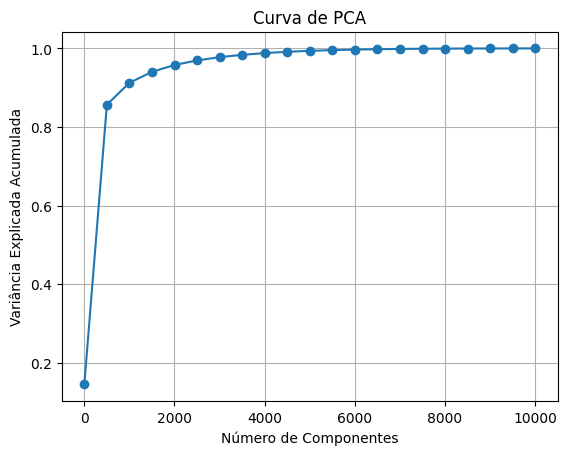

In [11]:
var_exp_acumulada = np.cumsum(pca.explained_variance_ratio_)

x = range(1, len(var_exp_acumulada) + 1)
y = var_exp_acumulada

plt.plot(x[::500], y[::500], marker='o')

plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada')
plt.title('Curva de PCA')
plt.grid(visible=True,zorder=1)
plt.show()

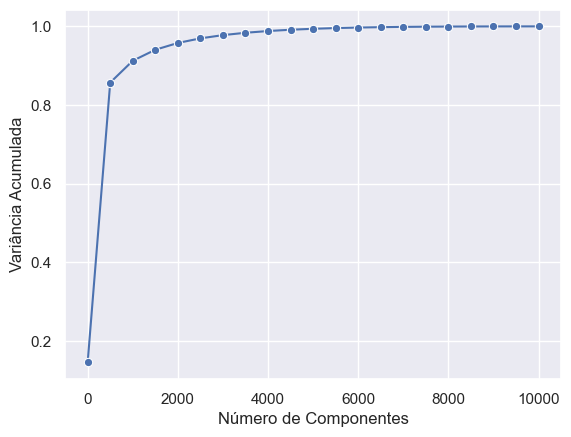

In [17]:
data = pd.DataFrame({'Número de Componentes': x[::500], 'Variância Acumulada': y[::500]})

sns.set_theme()

sns.lineplot(data=data, x='Número de Componentes', y='Variância Acumulada', marker='o')

plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada')
plt.grid(visible=True, zorder=1)
plt.show()

In [18]:
y[2000]

0.9577846918172962

Conforme evidenciado no gráfico, é possível identificar que cerca de 95% da variância dos dados é representada por apenas 2000 componentes. 

Essa descoberta permite reduzir significativamente o número de componentes necessários para representar os dados, passando de 10115 para 2000, o que representa uma redução de aproximadamente 80,2%. 

Essa redução considerável no número de componentes preserva a essência das informações contidas nos dados, ao mesmo tempo em que simplifica a representação e o processamento desses dados.

Logo, iremos realizar o PCA novamente com 2000 componentes para gerarmos nosso X de entrada dos nossos modelos

In [19]:
pca = PCA(random_state=911, n_components=2000)
x_pca = pca.fit_transform(df_features)

#### Clusterização K-means

In [20]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=911, n_init="auto").fit(x_pca)

In [21]:
kmeans_labels = kmeans.predict(x_pca)

In [22]:
kmeans_prediction = pd.concat([features['image_name'], pd.DataFrame({'label': kmeans_labels})], axis=1)
kmeans_prediction

,image_name,label
0,Image15187_v12.png,0
1,Image34383_v5.png,1
2,Image12583_v5.png,1
3,Image1943_v5.png,1
4,Image25559_v5.png,1
...,...,...
10110,Image6503_v2.png,0
10111,Image32843_v2.png,0
10112,Image9087_v2.png,0
10113,Image44359_v5.png,1


In [23]:
# Reduzir a dimensionalidade dos dados para plotar em 2D
pca = PCA(n_components=2)
X_plot = pca.fit_transform(x_pca)

In [101]:
kmeans_prediction.rename(columns={'label':'Cluster'}, inplace=True)

In [102]:
kmeans_prediction

,image_name,Cluster
0,Image15187_v12.png,0
1,Image34383_v5.png,1
2,Image12583_v5.png,1
3,Image1943_v5.png,1
4,Image25559_v5.png,1
...,...,...
10110,Image6503_v2.png,0
10111,Image32843_v2.png,0
10112,Image9087_v2.png,0
10113,Image44359_v5.png,1


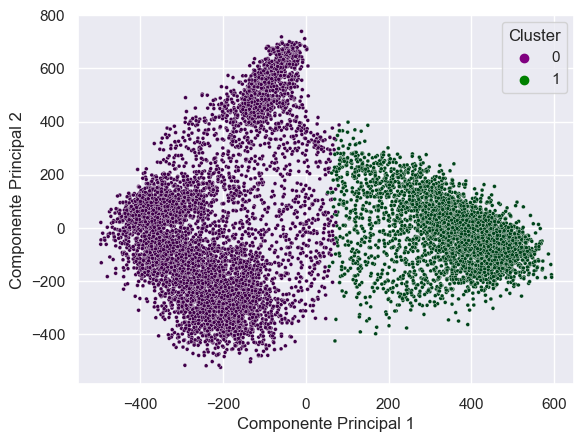

In [103]:
# Plotar os clusters

sns.set_theme()

scatter = sns.scatterplot(x=X_plot[:, 0], y=X_plot[:, 1], c=kmeans_prediction['Cluster'], s=8, hue=kmeans_prediction['Cluster'], palette=['purple', 'green'], cmap ="PRGn")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

#### CLusterização Fuzzy K-means

In [104]:
# Instanciar e treinar o modelo Fuzzy K-means
fcm = FCM(n_clusters=2, random_state=911)  # Substitua K pelo número de clusters desejado
fcm.fit(np.array(x_pca))

# Obter os rótulos dos clusters para cada amostra
fuzzy_labels = fcm.predict(np.array(x_pca))

# Obter as probabilidades de pertinência para cada amostra em cada cluster
probabilities = fcm.u

In [106]:
fuzzy_prediction = pd.concat([features['image_name'], pd.DataFrame({'Cluster': fuzzy_labels})], axis=1)
fuzzy_prediction

,image_name,Cluster
0,Image15187_v12.png,1
1,Image34383_v5.png,0
2,Image12583_v5.png,0
3,Image1943_v5.png,0
4,Image25559_v5.png,0
...,...,...
10110,Image6503_v2.png,1
10111,Image32843_v2.png,1
10112,Image9087_v2.png,1
10113,Image44359_v5.png,0


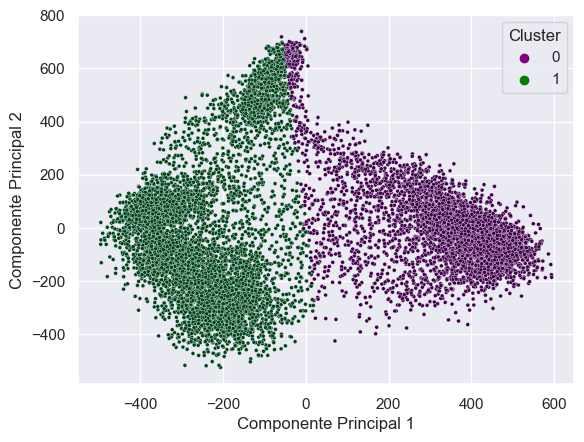

In [107]:
# Plotar os clusters

sns.set_theme()

scatter = sns.scatterplot(x=X_plot[:, 0], y=X_plot[:, 1], c=fuzzy_prediction['Cluster'], s=8, hue=fuzzy_prediction['Cluster'], palette=['purple', 'green'], cmap ="PRGn")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()